In [32]:
import sys
sys.path.append("..")
from simulations.elastic_collisions import Body, HiddenVariables, Variables, ElasticCollisionSimulation
import torch
from torch import Tensor
from torch.distributions import Distribution
from typing import Union, Callable
import optim

### The n-body collision problem

##### Visualise n body collision scenes for different bodies

#### Scenario 1 - Assumptions: 
- No force field (i.e. no air drag, attraction forces between bodies etc.)
- bodies are points of mass (a 'radius' value sets a range in which two close points are assumed to have collided)
- collisions are elastic (no loss of energy)
- the 'radius' values are the same and constant for each body
- the masses are the same and constant for each body 
- collisions with borders are also elastic
- the initial positions are fixed 

**Hidden variables:** initial velocity vectors

In [3]:

total_time = 10.0 
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
acceleration_coefficient_value = 0.0
constant_mass_value = 1.0
constant_radius_value = max_radius
velocity_distribution = torch.distributions.Uniform(low=-4, high=4)
position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)

num_bodies = 4
VARIABLES = Variables(
    masses = torch.full((num_bodies,), constant_mass_value),
    radii = torch.full((num_bodies,), constant_radius_value),
    starting_positions = None,
    initial_velocities= None,
    acceleration_coefficients = torch.full((num_bodies,), acceleration_coefficient_value),
    num_bodies = num_bodies,
    space_size = torch.tensor([space_size, space_size]),
)

initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(VARIABLES, position_distribution)
VARIABLES.starting_positions = initial_positions
print(f"initial_positions: {initial_positions}")

initial_velocities = velocity_distribution.sample(sample_shape=torch.Size([num_bodies, 2]))
print(f"initial_velocities: {initial_velocities}")


simulation = ElasticCollisionSimulation( variables=VARIABLES, 
                                         enable_logging=False, 
                                         noise=False)

HIDDENVARIABLES = HiddenVariables(num_bodies=None, 
                                  masses=None,
                                  radii=None,
                                  acceleration_coefficients=None, 
                                  initial_velocities=initial_velocities,)

result = simulation.simulate(hidden_variables=HIDDENVARIABLES, \
                             total_time=total_time, \
                             dt=dt)

position_history = simulation.get_position_history()
velocity_history = simulation.get_velocity_history()

print(f"position_history: {position_history}")

# assume that position history is of length num_bodies 
assert len(position_history) == num_bodies
assert len(velocity_history) == num_bodies

# print position histories for body 1 
print(f"position_history for body 1: {position_history[0]}")
print(f"time history for body 1: {len(position_history[0])}")

# Transform the history so that each element represents a timestep
position_history_by_timestep = list(map(list, zip(*position_history)))
velocity_history_by_timestep = list(map(list, zip(*velocity_history)))

num_timesteps = len(position_history_by_timestep)

print(f"position_history_by_timestep: {position_history_by_timestep}")

# Assume that position history is of length num_timesteps
assert len(position_history_by_timestep) == num_timesteps
assert len(velocity_history_by_timestep) == num_timesteps

# Print position histories for timestep 1
print(f"position_history for timestep 1: {position_history_by_timestep[0]}")
print(f"velocity_history for timestep 1: {velocity_history_by_timestep[0]}")

print(f"position of body 1 at timestep 1: {position_history_by_timestep[0][0]}")
print(f"velocity of body 1 at timestep 1: {velocity_history_by_timestep[0][0]}")



initial_positions: tensor([[4.8341, 1.2557],
        [1.7783, 4.9520],
        [6.2752, 3.3353],
        [8.5013, 5.6351]])
initial_velocities: tensor([[ 2.4673,  1.8910],
        [ 1.7528, -1.3119],
        [-1.9534, -3.5997],
        [ 0.3082, -2.0825]])
position_history: [[tensor([5.0808, 1.4448]), tensor([4.9394, 1.0393]), tensor([4.8027, 0.6411]), tensor([4.6661, 1.0393]), tensor([4.5294, 1.4376]), tensor([4.3927, 1.8358]), tensor([4.2560, 2.2341]), tensor([4.1193, 2.6324]), tensor([4.3584, 2.5222]), tensor([4.5850, 2.4289]), tensor([4.8116, 2.3357]), tensor([5.0382, 2.2424]), tensor([5.2648, 2.1492]), tensor([5.4914, 2.0559]), tensor([5.7180, 1.9626]), tensor([5.9446, 1.8694]), tensor([5.9742, 1.5387]), tensor([6.0090, 1.2142]), tensor([6.0438, 0.8898]), tensor([6.0786, 1.2142]), tensor([6.1134, 1.5387]), tensor([6.1481, 1.8631]), tensor([6.1829, 2.1875]), tensor([6.1080, 2.3229]), tensor([6.0335, 2.4589]), tensor([5.9589, 2.5949]), tensor([5.8844, 2.7309]), tensor([5.8099, 2.866

In [4]:
# added collision history 

collision_history_by_timestep = simulation.get_collision_history_per_timestep()

In [5]:
# loop though collision history by timestep and print out the collision history
for timestep, collisions in collision_history_by_timestep.items():
    print(f"timestep {timestep}:")
    for collision in collisions:

        # if there is key "boundary" then use that instead of body2 
        if "boundary" in collision:
            print(f"collision at time {collision['time']}: body {collision['body1']} and boundary {collision['boundary']}")
        else:
            print(f"collision at time {collision['time']}: body {collision['body1']} and body {collision['body2']}")

timestep 0:
timestep 1:
collision at time 0.1: body 0 and body 2
timestep 2:
timestep 3:
collision at time 0.30000000000000004: body 0 and boundary 1
timestep 4:
timestep 5:
collision at time 0.5: body 2 and body 3
timestep 6:
timestep 7:
collision at time 0.7000000000000001: body 3 and boundary 0
timestep 8:
collision at time 0.8: body 0 and body 1
timestep 9:
timestep 10:
timestep 11:
collision at time 1.1: body 2 and body 3
timestep 12:
timestep 13:
timestep 14:
timestep 15:
timestep 16:
collision at time 1.6: body 0 and body 3
timestep 17:
timestep 18:
timestep 19:
collision at time 1.9000000000000001: body 0 and boundary 1
timestep 20:
collision at time 2.0: body 1 and boundary 0
timestep 21:
timestep 22:
timestep 23:
collision at time 2.3000000000000003: body 0 and body 3
collision at time 2.3000000000000003: body 1 and boundary 1
timestep 24:
timestep 25:
timestep 26:
collision at time 2.6: body 1 and body 2
timestep 27:
timestep 28:
timestep 29:
timestep 30:
collision at time 3

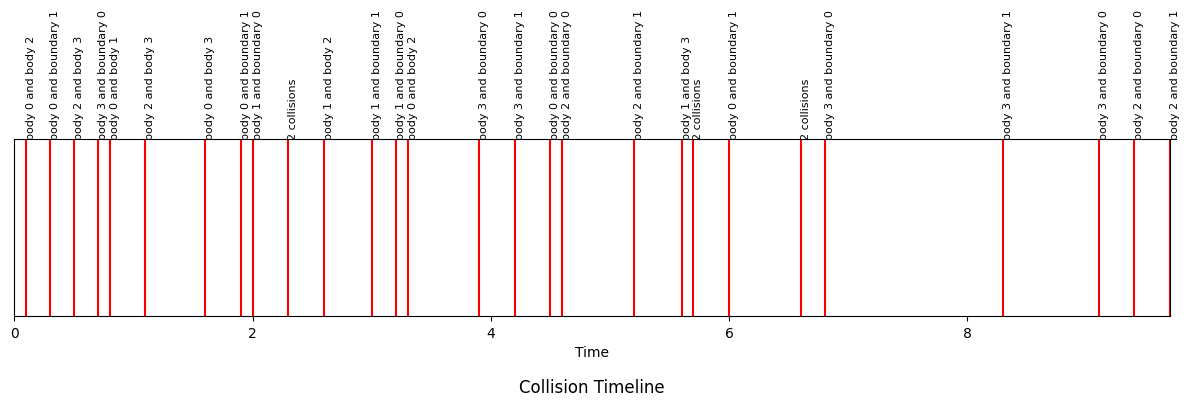

In [6]:
import matplotlib.pyplot as plt

# Get the total time span
total_time = max(collision['time'] for collisions in collision_history_by_timestep.values() for collision in collisions)

# Create a new figure
plt.figure(figsize=(12, 5))

# Loop through collision history by timestep
for timestep, collisions in collision_history_by_timestep.items():
    
    if len(collisions) == 1:
        collision = collisions[0]
        
        # Draw a vertical line at the time of the collision
        plt.vlines(collision['time'], 0, 1, colors='r')

        # Annotate the collision with smaller font size
        if "boundary" in collision:
            plt.text(collision['time'], 1, f"body {collision['body1']} and boundary {collision['boundary']}", rotation=90, verticalalignment='bottom', fontsize=8)
        else:
            plt.text(collision['time'], 1, f"body {collision['body1']} and body {collision['body2']}", rotation=90, verticalalignment='bottom', fontsize=8)
    elif len(collisions) > 1:
        collision = collisions[0]

        plt.vlines(collision['time'], 0, 1, colors='r')
        plt.text(collision['time'], 1, f"{len(collisions)} collisions", rotation=90, verticalalignment='bottom', fontsize=8)


# Set the limits and labels
plt.xlim(0, total_time)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.yticks([])
ax = plt.gca()  # get current axes
ax.text(0.5, -0.4, 'Collision Timeline', ha='center', va='center', transform=ax.transAxes, fontsize=12)


# Show the plot
plt.tight_layout()
plt.savefig('collision_timeline.png')
plt.show()

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_timestep(ax, positions, velocities, space_size, max_radius):
    # Normalize the velocity vectors
    normalized_velocities = velocities / np.linalg.norm(velocities, axis=1, keepdims=True) * space_size

    # Set the limits of the plot
    ax.set_xlim([0, space_size])
    ax.set_ylim([0, space_size])

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Add a grid
    ax.grid(True)

    # Convert positions list to numpy array
    positions = np.array(positions)

    # Plot the positions of the bodies
    ax.scatter(positions[:, 0], positions[:, 1], color='b')

    # Add transparent circles at the location of each body
    for pos in positions:
        circle = patches.Circle((pos[0], pos[1]), radius=max_radius, alpha=0.5, edgecolor='none')
        ax.add_patch(circle)

    # Plot the normalized velocities as vectors and display the original velocity values
    for pos, vel, orig_vel in zip(positions, normalized_velocities, velocities):
        ax.quiver(pos[0], pos[1], vel[0], vel[1], color='r')
        ax.text(pos[0] + orig_vel[0]/2, pos[1] + orig_vel[1]/2, f'({orig_vel[0]:.2f}, {orig_vel[1]:.2f})', color='r', fontsize=40)

# Number of timesteps to plot
num_timesteps = 40

# Create a new figure with a grid of subplots
fig, axs = plt.subplots(8, 5, figsize=(80, 120))  # 5 rows, 8 columns

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop over the timesteps
for i in range(num_timesteps):
    # Get the positions and velocities for this timestep
    positions = position_history_by_timestep[i]
    velocities = velocity_history_by_timestep[i]

    # Plot this timestep
    plot_timestep(axs[i], positions, velocities, space_size, max_radius)
    axs[i].set_title(f'Timestep {i}', fontsize=46)


# Adjust the space between subplots to be minimal
#plt.subplots_adjust(wspace=0.01, hspace=0.1)
# Display the plot
plt.tight_layout()
plt.show()
    #

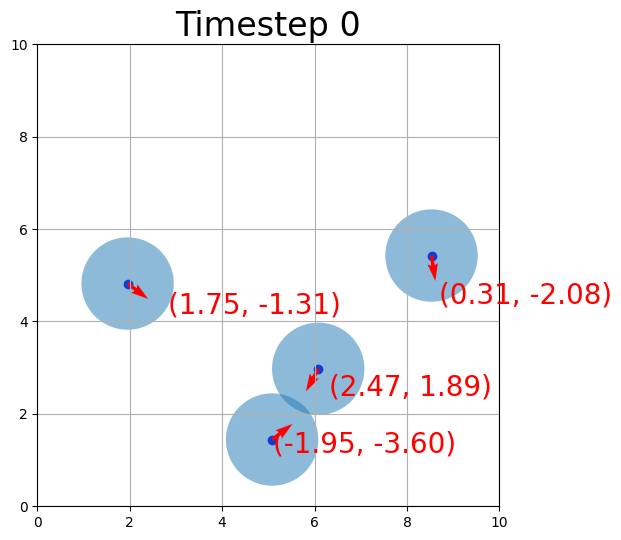

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

def plot_timestep(i):
    ax.clear()
    positions = position_history_by_timestep[i]
    velocities = velocity_history_by_timestep[i]
    normalized_velocities = velocities / np.linalg.norm(velocities, axis=1, keepdims=True) * space_size

    ax.set_xlim([0, space_size])
    ax.set_ylim([0, space_size])
    ax.set_aspect('equal')
    ax.grid(True)

    positions = np.array(positions)
    ax.scatter(positions[:, 0], positions[:, 1], color='b')

    for pos in positions:
        circle = patches.Circle((pos[0], pos[1]), radius=max_radius, alpha=0.5, edgecolor='none')
        ax.add_patch(circle)

    for pos, vel, orig_vel in zip(positions, normalized_velocities, velocities):
        ax.quiver(pos[0], pos[1], vel[0], vel[1], color='r')
        ax.text(pos[0] + orig_vel[0]/2, pos[1] + orig_vel[1]/2, f'({orig_vel[0]:.2f}, {orig_vel[1]:.2f})', color='r', fontsize=20)

    ax.set_title(f'Timestep {i}', fontsize=24)

num_timesteps = 100
fig, ax = plt.subplots(figsize=(10, 6))

ani = animation.FuncAnimation(fig, plot_timestep, frames=num_timesteps, interval=200)
# Save the animation as a GIF
ani.save('animation.gif', writer=PillowWriter(fps=10))

In [10]:

position_history = simulation.get_position_history()
position_history_by_timestep_list = list(map(list, zip(*position_history)))
#position_history_by_timestep_list = list(map(list, zip(*position_history)))
print(position_history_by_timestep_list)
print(len(position_history_by_timestep_list))


[[tensor([5.0808, 1.4448]), tensor([1.9536, 4.8208]), tensor([6.0799, 2.9753]), tensor([8.5321, 5.4269])], [tensor([4.9394, 1.0393]), tensor([2.1289, 4.6897]), tensor([6.2727, 3.2099]), tensor([8.5629, 5.2186])], [tensor([4.8027, 0.6411]), tensor([2.3042, 4.5585]), tensor([6.4607, 3.4373]), tensor([8.5938, 5.0104])], [tensor([4.6661, 1.0393]), tensor([2.4794, 4.4273]), tensor([6.6488, 3.6647]), tensor([8.6246, 4.8021])], [tensor([4.5294, 1.4376]), tensor([2.6547, 4.2961]), tensor([6.8369, 3.8921]), tensor([8.6554, 4.5939])], [tensor([4.3927, 1.8358]), tensor([2.8300, 4.1649]), tensor([6.7394, 4.0093]), tensor([8.9718, 4.4958])], [tensor([4.2560, 2.2341]), tensor([3.0053, 4.0337]), tensor([6.6443, 4.1274]), tensor([9.2858, 4.3969])], [tensor([4.1193, 2.6324]), tensor([3.1805, 3.9025]), tensor([6.5491, 4.2455]), tensor([8.9718, 4.2979])], [tensor([4.3584, 2.5222]), tensor([2.9800, 4.2798]), tensor([6.4540, 4.3636]), tensor([8.6578, 4.1989])], [tensor([4.5850, 2.4289]), tensor([2.7920, 4.

In [11]:

t_tensor_list = [torch.stack(t_l).flatten() for t_l in position_history_by_timestep_list]
result = torch.stack(t_tensor_list, dim=0)
print(result.shape)
print(result)

torch.Size([100, 8])
tensor([[5.0808, 1.4448, 1.9536, 4.8208, 6.0799, 2.9753, 8.5321, 5.4269],
        [4.9394, 1.0393, 2.1289, 4.6897, 6.2727, 3.2099, 8.5629, 5.2186],
        [4.8027, 0.6411, 2.3042, 4.5585, 6.4607, 3.4373, 8.5938, 5.0104],
        [4.6661, 1.0393, 2.4794, 4.4273, 6.6488, 3.6647, 8.6246, 4.8021],
        [4.5294, 1.4376, 2.6547, 4.2961, 6.8369, 3.8921, 8.6554, 4.5939],
        [4.3927, 1.8358, 2.8300, 4.1649, 6.7394, 4.0093, 8.9718, 4.4958],
        [4.2560, 2.2341, 3.0053, 4.0337, 6.6443, 4.1274, 9.2858, 4.3969],
        [4.1193, 2.6324, 3.1805, 3.9025, 6.5491, 4.2455, 8.9718, 4.2979],
        [4.3584, 2.5222, 2.9800, 4.2798, 6.4540, 4.3636, 8.6578, 4.1989],
        [4.5850, 2.4289, 2.7920, 4.6401, 6.3589, 4.4817, 8.3437, 4.1000],
        [4.8116, 2.3357, 2.6040, 5.0004, 6.2638, 4.5998, 8.0297, 4.0010],
        [5.0382, 2.2424, 2.4160, 5.3607, 6.0319, 4.7642, 7.8524, 3.8557],
        [5.2648, 2.1492, 2.2280, 5.7210, 5.8065, 4.9265, 7.6687, 3.7125],
        [5.4914, 

In [17]:
import torch
import torch

HIDDENVARIABLES = HiddenVariables(num_bodies=None, 
                                  masses=None,
                                  radii=None,
                                  acceleration_coefficients=None, 
                                  initial_velocities=initial_velocities,)


labels = ["num_bodies", "masses", "radii", "acceleration_coefficients", "initial_v"]

def prior_fn_basic(n_samples: int = 1) -> torch.Tensor:
    constant_mass_value = 1.0
    constant_radius_value = max_radius
    acceleration_coefficient_value = 0.0
    velocity_distribution = torch.distributions.Uniform(low=-4, high=4)

    num_bodies = torch.tensor(2)
    masses = torch.full((num_bodies,), constant_mass_value)
    radii = torch.full((num_bodies,), constant_radius_value)
    a_coeffs = torch.full((num_bodies,), acceleration_coefficient_value)
    initial_v = velocity_distribution.sample(sample_shape=torch.Size([num_bodies, 2]))


    flattened_tensors = torch.cat([torch.flatten(num_bodies),
                                   torch.flatten(masses),
                                   torch.flatten(radii),
                                   torch.flatten(a_coeffs),
                                   torch.flatten(initial_v)], dim=0)
    
    # concatenate flattened tensors n_samples times
    return torch.stack([flattened_tensors for _ in range(n_samples)], dim=0)


In [36]:

# prior and simulation interfaces
class Prior:
    def __init__(self, prior_fn, labels):
        self.prior_fn = prior_fn
        self.labels = labels
        self.mean = None
        self.std = None
        
    def sample(self, num_samples: int = 1) -> torch.Tensor:
        samples = self.prior_fn(num_samples)
        self.mean = torch.mean(samples)
        self.std = torch.std(samples)
        return samples
        
    def get_stats(self):
        if self.mean is None and self.std is None:
            raise ValueError("Sample first before getting stats")
        else:
            return self.mean, self.std
    
    def get_labels(self):
        return self.labels

In [37]:
basic_prior = Prior(prior_fn_basic, labels)
some_X = basic_prior.sample(1)
print(f"some_X: {some_X}")

some_X: tensor([[ 2.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  3.6746,
         -2.1132,  3.2687,  2.2297]])


In [38]:
import torch
import torch
# data set creation 
# X - input data - position histories by timestep 
# Y - ouput data - hidden varriables 


def simulate_collisions_simple(Y_i, VARIABLES, total_time, dt):

    position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)
    HIDDENVARIABLES = HiddenVariables.from_tensor(Y_i)

    initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(VARIABLES, position_distribution)
    VARIABLES.starting_positions = initial_positions

    simulation = ElasticCollisionSimulation(variables=VARIABLES, 
                                            enable_logging=False, 
                                            noise=False)

    _ = simulation.simulate(hidden_variables=HIDDENVARIABLES, \
                            total_time=total_time, \
                            dt=dt)
    
    position_history_by_timestep_list = list(map(list, zip(*position_history)))
    t_tensor_list = [torch.stack(t_l).flatten() for t_l in position_history_by_timestep_list]
    return torch.stack(t_tensor_list, dim=0)

    
# Generate a simulated training dataset using the SIR model and prior distribution
def generate_training_data(num_samples, VARIABLES, total_time,dt, prior):

    Y = prior.sample(num_samples)

    X = []
    for i in range(num_samples):
        # access entries in Y torch tensor along the -1th dimension
        Y_i = Y[i]

        # -------- create X values using the simulation function 
        X_i = simulate_collisions_simple(Y_i, VARIABLES, total_time, dt)
        X.append(X_i)

    # X is a list of tensors, convert to a single tensor
    X = torch.stack(X, dim=0)
    return X, Y



In [39]:
X_train, Y_train = generate_training_data(5, VARIABLES, total_time, dt, basic_prior)
print(f"X_train shape: {X_train.shape}")
print(f"X_train: {X_train}")

X_train shape: torch.Size([5, 100, 8])
X_train: tensor([[[5.0808, 1.4448, 1.9536,  ..., 2.9753, 8.5321, 5.4269],
         [4.9394, 1.0393, 2.1289,  ..., 3.2099, 8.5629, 5.2186],
         [4.8027, 0.6411, 2.3042,  ..., 3.4373, 8.5938, 5.0104],
         ...,
         [7.5635, 2.2021, 2.6465,  ..., 8.8798, 3.2294, 4.8701],
         [7.5632, 2.1794, 2.5795,  ..., 8.6994, 3.5982, 4.5788],
         [7.5629, 2.1568, 2.5124,  ..., 8.5190, 3.9670, 4.2875]],

        [[5.0808, 1.4448, 1.9536,  ..., 2.9753, 8.5321, 5.4269],
         [4.9394, 1.0393, 2.1289,  ..., 3.2099, 8.5629, 5.2186],
         [4.8027, 0.6411, 2.3042,  ..., 3.4373, 8.5938, 5.0104],
         ...,
         [7.5635, 2.2021, 2.6465,  ..., 8.8798, 3.2294, 4.8701],
         [7.5632, 2.1794, 2.5795,  ..., 8.6994, 3.5982, 4.5788],
         [7.5629, 2.1568, 2.5124,  ..., 8.5190, 3.9670, 4.2875]],

        [[5.0808, 1.4448, 1.9536,  ..., 2.9753, 8.5321, 5.4269],
         [4.9394, 1.0393, 2.1289,  ..., 3.2099, 8.5629, 5.2186],
         [

In [40]:
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_train: {Y_train}")

Y_train shape: torch.Size([5, 11])
Y_train: tensor([[ 2.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.1253,
          2.6509, -0.5949,  0.1780],
        [ 2.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000, -0.4076,
          0.0741,  0.8772,  2.5470],
        [ 2.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.8936,
         -1.8247,  1.7318,  0.5487],
        [ 2.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.7951,
         -1.8073,  1.6606,  0.8787],
        [ 2.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.4705,
         -1.1960,  1.9402,  0.2674]])


#### Training simple feed-forward predictor model

In [41]:
from torch import nn

# Define the neural network architecture
# simple feed forward fully connected neural network with num_l_layers
class ParameterPredictor(nn.Module):

    def __init__(self, input_size, hidden_size, num_l_layers: int = 1):
        super(ParameterPredictor, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1_s = self._build_fc_linear_layers(input_size, hidden_size, num_l_layers)
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size, 11)  # Output layer with 11 neurons for the output values

    def _build_fc_linear_layers(self, input_size, hidden_size, num_layers):
        layers = []
        if num_layers == 0:
            raise ValueError("num_layers must be greater than 0")
        elif num_layers == 1:
            return [nn.Linear(input_size, hidden_size)]
        elif num_layers > 1:
            return [nn.Linear(input_size, hidden_size)] + [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)]
        return layers

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.fc1_s:
            temp_x = layer(x)
            x = self.relu(temp_x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [42]:
total_time = 10.0 
num_bodies = 2
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
acceleration_coefficient_value = 0.0
constant_mass_value = 1.0
constant_radius_value = max_radius


VARIABLES = Variables(
        masses = torch.full((num_bodies,), constant_mass_value),
        radii = torch.full((num_bodies,), constant_radius_value),
        starting_positions = None,
        initial_velocities= None,
        acceleration_coefficients = torch.full((num_bodies,), acceleration_coefficient_value),
        num_bodies = num_bodies,
        space_size = torch.tensor([space_size, space_size]),
    )

In [28]:
# Define the number of training and test samples
num_train_samples = 80  # Adjust as needed
num_test_samples = 20   # Adjust as needed


# Generate training data
prior = Prior(prior_fn_basic, labels)
X_train, Y_train = generate_training_data(num_train_samples, VARIABLES, total_time,dt, prior)
# Generate test data
X_test, Y_test = generate_training_data(num_test_samples, VARIABLES, total_time, dt, prior)


print("Y_train shape:", Y_train.shape)
print("X_train shape:", X_train.shape)


print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Y_train shape: torch.Size([80, 11])
X_train shape: torch.Size([80, 100, 8])
X_test shape: torch.Size([20, 100, 8])
Y_test shape: torch.Size([20, 11])


In [29]:
def train_model(model, optimizer, criterion, num_samples, num_epochs, batch_size):
    
    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            inputs = X_train[i:i+batch_size]
            labels = Y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

In [34]:
# Create instances of the feature extractor and Conditional RealNVP
blocks = 10
num_epochs = 30
num_samples=80
hidden_size = 64
condition_size = hidden_size
f_input_size = 200
# Define the batch size
batch_size = 10


# Create the neural network
T = 100
input_size = T * 2  # Input shape is (T, 2) for X
hidden_size = 64
model = ParameterPredictor(input_size, hidden_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



c:\Users\jet95\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
# Training loop
num_epochs = 50
batch_size = 32
for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        inputs = X_train[i:i+batch_size]
        labels = Y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, Y_test)

print(f"Test loss: {test_loss.item()}")

NameError: name 'num_samples' is not defined

In [ ]:
# Lists to store results
hidden_sizes = [32, 64,128]  # Vary hidden layer size
train_set_sizes = [500, 1000, 2000]  # Vary training set size
accuracies = []

# Training loop
for hidden_size in hidden_sizes:
    for train_set_size in train_set_sizes:
        model = ParameterPredictor(input_size, hidden_size)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        X_train, Y_train = generate_training_data(train_set_size, T, prior_distribution)

        num_epochs = 50
        batch_size = 32
        losses = []

        for epoch in range(num_epochs):
            for i in range(0, train_set_size, batch_size):
                inputs = X_train[i:i+batch_size]
                labels = Y_train[i:i+batch_size]

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            losses.append(loss.item())

        # Evaluate the model on a simulated test set (similar to training data generation)
        X_test, Y_test = generate_training_data(num_samples, T, prior_distribution)
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, Y_test)

        
        accuracies.append(test_loss.item())

# Create a heatmap of accuracies
accuracies = np.array(accuracies).reshape(len(hidden_sizes), len(train_set_sizes))
plt.figure(figsize=(10, 6))
plt.imshow(accuracies, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Test Loss')
plt.xticks(np.arange(len(train_set_sizes)), train_set_sizes)
plt.yticks(np.arange(len(hidden_sizes)), hidden_sizes)
plt.xlabel('Training Set Size')
plt.ylabel('Hidden Layer Size')
plt.title('Accuracy Heatmap')
plt.show()